<a href="https://colab.research.google.com/github/MSTarakanov/CNN_genre_classification/blob/master/CNN_PyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Подключение основных библиотек

In [42]:
import os
import numpy as np
import librosa
import librosa.display
import IPython.display as ipd
from PIL import Image
import matplotlib
import matplotlib.pyplot as plt
import pylab

### Импорт файлов с гугл диска

In [43]:
from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


#### Проверка, что монтирование прошла успешно

In [44]:
DIRS = os.listdir('/gdrive/My Drive/Colab Notebooks/')
DIRS

['Untitled0.ipynb',
 'CNN.ipynb',
 'IDP.ipynb',
 'final.pt',
 'train',
 'test',
 'CNN_PyTorch.ipynb']

### Работа с PyTorch

Была выбрана библиотека PyTorch, так как в ней присутствует модель остаточной сверточной нейронной сети "ResNet 34", которая идеально подходит для распознавания изображений 

#### Подключение фреймворка

In [45]:
from __future__ import print_function 
from __future__ import division
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets, models, transforms
import time
import copy
print("Версия PyTorch: ", torch.__version__)
print("Версия Torchvision: ", torchvision.__version__)

Версия PyTorch:  1.8.1+cu101
Версия Torchvision:  0.9.1+cu101


#### Определим основные переменные и некоторые гиперпараметры сети, такие как:
- Число классов
- Размер батча
- Число эпох

In [46]:
data_dir = '/gdrive/My Drive/Colab Notebooks/'
model_name = 'resnet'
num_classes = 10
batch_size = 8
num_epochs = 15
feature_extract = False

#### Функция для обучения модели

In [47]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs=25, is_inception=False):
    since = time.time()

    val_acc_history = []
    
    best_model_wts = copy.deepcopy(model.state_dict())                           # копируем параметры обученной нейронной сети
    best_acc = 0.0                                                             

    for epoch in range(num_epochs):
        print('Эпоха {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        for phase in ['train', 'test']:                                          
            if phase == 'train':
                model.train()                                                    
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    if is_inception and phase == 'train':
                        outputs, aux_outputs = model(inputs)
                        loss1 = criterion(outputs, labels)
                        loss2 = criterion(aux_outputs, labels)
                        loss = loss1 + 0.4*loss2
                    else:
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('Данные: {:6s} Значение фунцкии потерь: {:.4f} Точность: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            if phase == 'test' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'test':
                val_acc_history.append(epoch_acc)

        print()

    time_elapsed = time.time() - since
    print('Обучение закончено за {:.0f}м {:.0f}с'.format(time_elapsed // 60, time_elapsed % 60))
    print('Лучшая точность: {:4f}'.format(best_acc))

    model.load_state_dict(best_model_wts)
    return model, val_acc_history

##### Функции для инициализации модели и начала работы с моделью ResNet 34

In [48]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False
def initialize_model(model_name, num_classes, feature_extract, use_pretrained=True):
    """
    Функция для инициализация модели
    принимает на вход имя сети, число классов
    Также, мы указали, что не хотим переобучать всю сеть, а хотим использовать преобученную ResNet34 
    """
    model_ft = None
    input_size = 0
    
    if model_name == "resnet":
        """ RESNET 34
        """
        model_ft = models.resnet34(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
        input_size = 224
    
    return model_ft, input_size

#### Инициализация модели

In [49]:
model_ft, input_size = initialize_model(model_name, num_classes, feature_extract, use_pretrained=True)

#### Представление датасета в виде матрицы и нормализация данных

In [50]:
data_transforms = {
    'train': transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'test']}

dataloaders_dict = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=4) for x in ['train', 'test']}



/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


#### Выбор ресурсов для обучения модели (предпочтительно GPU)

In [51]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model_ft = model_ft.to(device)

Параметры в модели, которые можно и нужно обновлять при нашем обучении,
так как мы взяли уже обученную большую модель ResNet 34 и мы ее __до__обучаем:

In [52]:
params_to_update = model_ft.parameters()
print("Параметры для обучения:")
if feature_extract:
    params_to_update = []
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            print("\t",name)

Параметры для обучения:
	 conv1.weight
	 bn1.weight
	 bn1.bias
	 layer1.0.conv1.weight
	 layer1.0.bn1.weight
	 layer1.0.bn1.bias
	 layer1.0.conv2.weight
	 layer1.0.bn2.weight
	 layer1.0.bn2.bias
	 layer1.1.conv1.weight
	 layer1.1.bn1.weight
	 layer1.1.bn1.bias
	 layer1.1.conv2.weight
	 layer1.1.bn2.weight
	 layer1.1.bn2.bias
	 layer1.2.conv1.weight
	 layer1.2.bn1.weight
	 layer1.2.bn1.bias
	 layer1.2.conv2.weight
	 layer1.2.bn2.weight
	 layer1.2.bn2.bias
	 layer2.0.conv1.weight
	 layer2.0.bn1.weight
	 layer2.0.bn1.bias
	 layer2.0.conv2.weight
	 layer2.0.bn2.weight
	 layer2.0.bn2.bias
	 layer2.0.downsample.0.weight
	 layer2.0.downsample.1.weight
	 layer2.0.downsample.1.bias
	 layer2.1.conv1.weight
	 layer2.1.bn1.weight
	 layer2.1.bn1.bias
	 layer2.1.conv2.weight
	 layer2.1.bn2.weight
	 layer2.1.bn2.bias
	 layer2.2.conv1.weight
	 layer2.2.bn1.weight
	 layer2.2.bn1.bias
	 layer2.2.conv2.weight
	 layer2.2.bn2.weight
	 layer2.2.bn2.bias
	 layer2.3.conv1.weight
	 layer2.3.bn1.weight
	 layer2

#### Выбор гиперпарамеров нейронной сети, таких как
- Метод оптимизации
- Коэффициент скорости обучения (уменьшается с каждым шагом обучения)
- Функция потерь

In [53]:
optimizer_ft = optim.Adam(params_to_update, lr=0.00001)
exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer_ft, step_size=2, gamma=0.1)
criterion = nn.CrossEntropyLoss()

#### Обучение нейронной сети

In [56]:
model_ft, hist = train_model(model_ft, dataloaders_dict, criterion, optimizer_ft, num_epochs=num_epochs, is_inception=(model_name=="inception"))

Эпоха 0/14
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Данные: train  Значение фунцкии потерь: 0.0656 Точность: 0.9921
Данные: test   Значение фунцкии потерь: 1.2266 Точность: 0.6700

Эпоха 1/14
----------
Данные: train  Значение фунцкии потерь: 0.0564 Точность: 0.9921
Данные: test   Значение фунцкии потерь: 1.2241 Точность: 0.6667

Эпоха 2/14
----------
Данные: train  Значение фунцкии потерь: 0.0582 Точность: 0.9942
Данные: test   Значение фунцкии потерь: 1.2794 Точность: 0.6700

Эпоха 3/14
----------
Данные: train  Значение фунцкии потерь: 0.0362 Точность: 0.9958
Данные: test   Значение фунцкии потерь: 1.2867 Точность: 0.6733

Эпоха 4/14
----------
Данные: train  Значение фунцкии потерь: 0.0347 Точность: 0.9967
Данные: test   Значение фунцкии потерь: 1.2580 Точность: 0.6983

Эпоха 5/14
----------
Данные: train  Значение фунцкии потерь: 0.0299 Точность: 0.9967
Данные: test   Значение фунцкии потерь: 1.2248 Точность: 0.7050

Эпоха 6/14
----------
Данные: train  Значение фунцкии потерь: 0.0248 Точность: 0.9992
Данные: test   Значение фунцки

#### Вывод результатов обучения

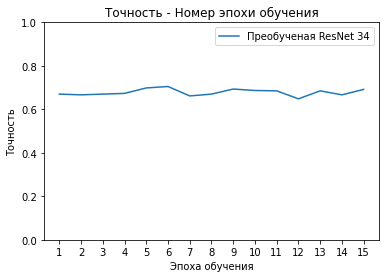

In [57]:
ohist = [h.cpu().numpy() for h in hist]
plt.title("Точность - Номер эпохи обучения")
plt.xlabel("Эпоха обучения")
plt.ylabel("Точность")
plt.plot(range(1,num_epochs+1),ohist,label="Преобученая ResNet 34")
plt.ylim((0,1.))
plt.xticks(np.arange(1, num_epochs+1, 1.0))
plt.legend()
plt.show()

#### Сохранение лучшей модели (всех ее параметров) на гугл диск

In [55]:
torch.save(model_ft, '/gdrive/My Drive/Colab Notebooks/final.pt')